In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from datetime import datetime
from pathlib import Path

# Plotting style - match wva_analysis.ipynb
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


# WVA Capacity-Based Mode Analysis

This notebook analyzes WVA (Workload Variant Autoscaler) experiments running in **CAPACITY-ONLY mode**.

## Key Metrics

### Resource Utilization
- **KV Cache Usage** - Per-pod KV cache utilization percentage
- **Queue Length** - Number of waiting requests per pod

### Saturation Detection
- **Saturated Pods** - Pods exceeding KV cache threshold (typically 90%)
- **Queue Buildup** - Pods with queue length exceeding threshold (typically 10)

### Performance Metrics
- **TTFT (Time to First Token)** - Latency to first token in milliseconds
- **ITL (Inter-Token Latency)** - Average latency between tokens in milliseconds

### Scaling Behavior
- **Scale-Up Triggers** - When saturation detected
- **Scale-Down Safety** - When all pods have low utilization and empty queues
- **Current Replicas** - Actual running replicas

## Visualizations

This notebook generates comprehensive plots with styling consistent with HPA experiments:

- **Individual Metrics**: KV Cache, Queue Length, Latencies, Replica Scaling
- **Combined Summary**: Multi-panel overview for quick comparison
- **Per-Pod Analysis**: Individual pod KV cache utilization
- **Scaling Context**: Scaling decisions overlaid with KV cache metrics

## Workflow

1. Load experiment data from timestamped directory
2. Parse WVA controller logs
3. Extract KV cache and queue metrics per pod
4. Parse performance metrics (TTFT, ITL)
5. Analyze saturation patterns
6. Generate visualizations with consistent styling
7. Export processed data and summary report


## 1. Setup and Configuration

## Quick Start Guide

**To analyze your experiment:**

1. Run cells 1-5 to load and parse data
2. Review the summary statistics in cell 11
3. Run individual visualization cells (sections 6-8) to see specific metrics
4. Check scaling events in section 9
5. Export processed data in section 11

**Individual Metric Plots (one per cell):**
- **Section 6**: KV Cache Utilization
- **Section 7**: Queue Length  
- **Section 7.5**: TTFT & ITL Latencies
- **Section 7.7**: Arrival Rate
- **Section 8**: Replica Scaling
- **Section 8.5**: Combined Summary (all metrics in one multi-panel view)
- **Section 9**: Scaling Events Details
- **Section 10**: Per-Pod KV Cache Timeline

**Note:** Some plots may appear empty if:
- The experiment is still early (no data collected yet)
- Metrics are all zero (e.g., TTFT/ITL when no requests are being processed)
- No scaling events have occurred yet

---

## 1. Setup and Configuration

In [10]:
import json
import sys
import re
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Libraries imported successfully")

KV_CACHE_THRESHOLD = 0.5  # Latency threshold in milliseconds to consider KV cache hit
QUEUE_LENGTH_THRESHOLD = 5  # Queue length threshold to consider queuing delay significant
SHOW_DESIRED_REPLICAS = True  # Whether to show desired replicas in the plot

✓ Libraries imported successfully


## 2. Select Experiment Directory

In [11]:
# Auto-detect latest capacity-based experiment
data_dir = Path('./experiment-data')
if data_dir.exists():
    experiments = sorted(data_dir.glob('capacity-based-*'), reverse=True)
    if experiments:
        EXPERIMENT_DIR = str(experiments[0])
        print(f"✓ Auto-detected latest experiment: {experiments[0].name}")
    else:
        EXPERIMENT_DIR = './experiment-data/capacity-based-moderate-load-20251126-120000'
        print(f"⚠ No capacity-based experiments found, using example path")
else:
    EXPERIMENT_DIR = './experiment-data/capacity-based-moderate-load-20251126-120000'
    print(f"⚠ Data directory not found, using example path")

EXPERIMENT_DIR = Path(EXPERIMENT_DIR)
# EXPERIMENT_DIR = Path('./experiment-data/capacity-based-high-parallel-20251128-145238')
# EXPERIMENT_DIR = Path('./experiment-data/capacity-based-high-parallel-20251128-152808')
EXPERIMENT_DIR = Path('./experiment-data/capacity-based-high-parallel-20251128-155627')
LOG_FILE = EXPERIMENT_DIR / 'wva-controller-logs.jsonl'
METRICS_CSV = EXPERIMENT_DIR / 'metrics.csv'

print(f"Experiment directory: {EXPERIMENT_DIR}")
print(f"Log file: {LOG_FILE}")
print(f"Metrics CSV: {METRICS_CSV}")

# Verify files exist
if not EXPERIMENT_DIR.exists():
    print(f"❌ Experiment directory not found: {EXPERIMENT_DIR}")
    print(f"Please run an experiment first with: ./run-experiment.sh experiment-configs/capacity-based-moderate.yaml")
elif not LOG_FILE.exists():
    print(f"❌ Log file not found: {LOG_FILE}")
else:
    print(f"✓ Files found")

✓ Auto-detected latest experiment: capacity-based-moderate-parallel-20251127-205831
Experiment directory: experiment-data/capacity-based-high-parallel-20251128-155627
Log file: experiment-data/capacity-based-high-parallel-20251128-155627/wva-controller-logs.jsonl
Metrics CSV: experiment-data/capacity-based-high-parallel-20251128-155627/metrics.csv
✓ Files found


## 3. Parse WVA Logs

Extract key events from WVA controller logs:
- **KV Cache Metrics** - Per-pod cache utilization
- **Queue Metrics** - Per-pod request queue length
- **Capacity Analysis** - Saturation detection and scaling decisions
- **Overall Metrics** - Aggregate ITL/TTFT/replicas

In [12]:
def parse_wva_logs(log_file):
    """Parse WVA controller logs for capacity-based experiments."""
    
    kv_cache_metrics = []
    queue_metrics = []
    capacity_analysis = []
    overall_metrics = []
    scaling_decisions = []
    
    print("Parsing WVA controller logs...")
    with open(log_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            try:
                log = json.loads(line.strip())
                ts = log.get('ts', '')
                msg = log.get('msg', '')
                level = log.get('level', '')
                
                # Convert timestamp to datetime
                try:
                    dt = datetime.fromisoformat(ts.replace('Z', '+00:00'))
                except:
                    continue
                
                # Extract KV cache metrics (only if pod name is found)
                if 'KV cache metric' in msg:
                    pod_match = re.search(r'pod=([a-zA-Z0-9-]+)', msg)
                    usage_match = re.search(r'usage=([0-9.]+)', msg)
                    pct_match = re.search(r'\(([0-9.]+)%\)', msg)
                    
                    if pod_match:  # Only append if pod name is successfully extracted
                        kv_cache_metrics.append({
                            'timestamp': dt,
                            'pod': pod_match.group(1),
                            'kv_cache_usage': float(usage_match.group(1)) if usage_match else None,
                            'kv_cache_pct': float(pct_match.group(1)) if pct_match else None
                        })
                
                # Extract queue metrics (only if pod name is found)
                elif 'Queue metric' in msg:
                    pod_match = re.search(r'pod=([a-zA-Z0-9-]+)', msg)
                    queue_match = re.search(r'queueLength=([0-9]+)', msg)
                    
                    if pod_match:  # Only append if pod name is successfully extracted
                        queue_metrics.append({
                            'timestamp': dt,
                            'pod': pod_match.group(1),
                            'queue_length': int(queue_match.group(1)) if queue_match else None
                        })
                
                # Extract capacity analysis
                elif 'Capacity analysis completed' in msg:
                    total_match = re.search(r'totalReplicas=([0-9]+)', msg)
                    nonsaturated_match = re.search(r'nonSaturated=([0-9]+)', msg)
                    scaleup_match = re.search(r'shouldScaleUp=(true|false)', msg)
                    scaledown_match = re.search(r'scaleDownSafe=(true|false)', msg)
                    
                    capacity_analysis.append({
                        'timestamp': dt,
                        'total_replicas': int(total_match.group(1)) if total_match else None,
                        'non_saturated': int(nonsaturated_match.group(1)) if nonsaturated_match else None,
                        'should_scale_up': scaleup_match.group(1) == 'true' if scaleup_match else None,
                        'scale_down_safe': scaledown_match.group(1) == 'true' if scaledown_match else None
                    })
                
                # Extract overall metrics (FIXED: removed ✓ checkmark)
                elif 'Metrics collected for VA' in msg:
                    replicas_match = re.search(r'replicas=([0-9]+)', msg)
                    ttft_match = re.search(r'ttft=([0-9.]+)', msg)
                    itl_match = re.search(r'itl=([0-9.]+)', msg)
                    cost_match = re.search(r'cost=([0-9.]+)', msg)
                    
                    # Extract values and remove 'ms' suffix if present
                    ttft_str = ttft_match.group(1) if ttft_match else None
                    itl_str = itl_match.group(1) if itl_match else None
                    
                    if ttft_str:
                        ttft_val = float(ttft_str.replace('ms', ''))
                    else:
                        ttft_val = None
                        
                    if itl_str:
                        itl_val = float(itl_str.replace('ms', ''))
                    else:
                        itl_val = None
                    
                    overall_metrics.append({
                        'timestamp': dt,
                        'replicas': int(replicas_match.group(1)) if replicas_match else None,
                        'ttft': ttft_val,
                        'itl': itl_val,
                        'cost': float(cost_match.group(1)) if cost_match else None
                    })
                
                # Extract scaling decisions (capacity-based uses "Applied capacity decision")
                elif 'Applied capacity decision' in msg:
                    current_match = re.search(r'current=([0-9]+)', msg)
                    target_match = re.search(r'target=([0-9]+)', msg)
                    action_match = re.search(r'action=([a-z-]+)', msg)
                    reason_match = re.search(r'reason=([^"]+)', msg)
                    
                    scaling_decisions.append({
                        'timestamp': dt,
                        'current_replicas': int(current_match.group(1)) if current_match else None,
                        'target_replicas': int(target_match.group(1)) if target_match else None,
                        'action': action_match.group(1) if action_match else None,
                        'reason': reason_match.group(1).strip() if reason_match else None
                    })
                        
            except json.JSONDecodeError:
                continue
            except Exception as e:
                print(f"Error parsing line {line_num}: {e}")
                continue
    
    return kv_cache_metrics, queue_metrics, capacity_analysis, overall_metrics, scaling_decisions

# Parse the logs
kv_cache_metrics, queue_metrics, capacity_analysis, overall_metrics, scaling_decisions = parse_wva_logs(LOG_FILE)

# Convert to DataFrames
df_kv_cache = pd.DataFrame(kv_cache_metrics)
df_queue = pd.DataFrame(queue_metrics)
df_capacity = pd.DataFrame(capacity_analysis)
df_metrics = pd.DataFrame(overall_metrics)
df_scaling = pd.DataFrame(scaling_decisions)

# Remove duplicate scaling decisions (sometimes logged multiple times)
if len(df_scaling) > 0:
    original_count = len(df_scaling)
    df_scaling = df_scaling.drop_duplicates(subset=['timestamp', 'current_replicas', 'target_replicas', 'action'], keep='first')
    df_scaling = df_scaling.sort_values('timestamp').reset_index(drop=True)
    if original_count > len(df_scaling):
        print(f"⚠️  Removed {original_count - len(df_scaling)} duplicate scaling decision entries")

print(f"\n✓ Parsed {len(df_kv_cache)} KV cache measurements")
print(f"✓ Parsed {len(df_queue)} queue measurements")
print(f"✓ Parsed {len(df_capacity)} capacity analyses")
print(f"✓ Parsed {len(df_metrics)} overall metrics")
print(f"✓ Parsed {len(df_scaling)} scaling decisions (unique)")

# Show samples
if len(df_kv_cache) > 0:
    print("\nSample KV cache metric:")
    print(df_kv_cache.head(1).to_string())

if len(df_capacity) > 0:
    print("\nSample capacity analysis:")
    print(df_capacity.head(1).to_string())

if len(df_metrics) > 0:
    print("\nSample overall metrics:")
    print(df_metrics.head(1).to_string())

Parsing WVA controller logs...

✓ Parsed 330 KV cache measurements
✓ Parsed 330 queue measurements
✓ Parsed 288 capacity analyses
✓ Parsed 144 overall metrics
✓ Parsed 144 scaling decisions (unique)

Sample KV cache metric:
                         timestamp                                                              pod  kv_cache_usage  kv_cache_pct
0 2025-11-28 20:51:51.697000+00:00  ms-inference-scheduling-llm-d-modelservice-decode-789945f9l76md             0.0           0.0

Sample capacity analysis:
                         timestamp  total_replicas  non_saturated  should_scale_up  scale_down_safe
0 2025-11-28 20:51:51.697000+00:00               1              1            False            False

Sample overall metrics:
                         timestamp  replicas  ttft  itl  cost
0 2025-11-28 20:51:51.695000+00:00         1   0.0  0.0  10.0


## 4. Aggregate Per-Pod Metrics

Calculate average KV cache and queue metrics across all pods at each timestamp.

In [13]:
# Group by timestamp for KV cache
if len(df_kv_cache) > 0:
    df_kv_agg = df_kv_cache.groupby('timestamp').agg({
        'kv_cache_usage': ['mean', 'max', 'min'],
        'kv_cache_pct': ['mean', 'max', 'min']
    }).reset_index()
    
    df_kv_agg.columns = ['timestamp', 'kv_usage_mean', 'kv_usage_max', 'kv_usage_min',
                          'kv_pct_mean', 'kv_pct_max', 'kv_pct_min']
    
    print(f"✓ Aggregated KV cache metrics: {len(df_kv_agg)} timestamps")
else:
    df_kv_agg = pd.DataFrame()

# Group by timestamp for queue
if len(df_queue) > 0:
    df_queue_agg = df_queue.groupby('timestamp').agg({
        'queue_length': ['mean', 'max', 'min', 'sum']
    }).reset_index()
    
    df_queue_agg.columns = ['timestamp', 'queue_mean', 'queue_max', 'queue_min', 'queue_total']
    
    print(f"✓ Aggregated queue metrics: {len(df_queue_agg)} timestamps")
else:
    df_queue_agg = pd.DataFrame()

# Calculate relative time for all dataframes (like HPA notebook)
if len(df_metrics) > 0:
    start_time = df_metrics['timestamp'].min()
    df_metrics['time_relative'] = (df_metrics['timestamp'] - start_time).dt.total_seconds() / 60
    print(f"✓ Added relative time to metrics dataframe")

if len(df_kv_agg) > 0:
    start_time = df_kv_agg['timestamp'].min()
    df_kv_agg['time_relative'] = (df_kv_agg['timestamp'] - start_time).dt.total_seconds() / 60

if len(df_queue_agg) > 0:
    start_time = df_queue_agg['timestamp'].min()
    df_queue_agg['time_relative'] = (df_queue_agg['timestamp'] - start_time).dt.total_seconds() / 60

if len(df_scaling) > 0:
    start_time = df_scaling['timestamp'].min()
    df_scaling['time_relative'] = (df_scaling['timestamp'] - start_time).dt.total_seconds() / 60


✓ Aggregated KV cache metrics: 146 timestamps
✓ Aggregated queue metrics: 146 timestamps
✓ Added relative time to metrics dataframe


## 5. Summary Statistics

In [14]:
print("="*70)
print("WVA CAPACITY-BASED EXPERIMENT SUMMARY")
print("="*70)

if len(df_scaling) > 0:
    print(f"\nInitial Replicas:  {df_scaling['current_replicas'].iloc[0]}")
    print(f"Final Replicas:    {df_scaling['current_replicas'].iloc[-1]}")
    print(f"Max Replicas:      {df_scaling['current_replicas'].max()}")
    print(f"Min Replicas:      {df_scaling['current_replicas'].min()}")

print()
print("="*70)
print("CAPACITY METRICS")
print("="*70)

if len(df_kv_agg) > 0:
    print("\nKV Cache Utilization:")
    print(f"  Mean:   {df_kv_agg['kv_pct_mean'].mean():.2f}%")
    print(f"  Max:    {df_kv_agg['kv_pct_max'].max():.2f}%")
    print(f"  Min:    {df_kv_agg['kv_pct_min'].min():.2f}%")
    
    # Use actual threshold from WVA config
    saturated_count = (df_kv_agg['kv_pct_max'] > KV_CACHE_THRESHOLD*100).sum()
    saturated_pct = (saturated_count / len(df_kv_agg)) * 100
    print(f"  Saturation Events (>{KV_CACHE_THRESHOLD*100:.0f}%): {saturated_count}/{len(df_kv_agg)} ({saturated_pct:.1f}%)")
else:
    print("\nKV Cache Utilization: No data available")

if len(df_queue_agg) > 0:
    print("\nQueue Length:")
    print(f"  Mean:   {df_queue_agg['queue_mean'].mean():.2f} requests")
    print(f"  Max:    {df_queue_agg['queue_max'].max():.0f} requests")
    print(f"  Queue Buildup Events (>{QUEUE_LENGTH_THRESHOLD}): {(df_queue_agg['queue_max'] > QUEUE_LENGTH_THRESHOLD).sum()}")
else:
    print("\nQueue Length: No data available")

if len(df_metrics) > 0:
    # Check if we have any non-zero TTFT/ITL data
    has_ttft = (df_metrics['ttft'] > 0).any() if 'ttft' in df_metrics.columns else False
    has_itl = (df_metrics['itl'] > 0).any() if 'itl' in df_metrics.columns else False
    
    if has_ttft:
        ttft_data = df_metrics['ttft'][df_metrics['ttft'] > 0]
        print("\nTTFT (Time to First Token) ms:")
        print(f"  Mean:   {ttft_data.mean():.2f}")
        print(f"  Max:    {ttft_data.max():.2f}")
        print(f"  Min:    {ttft_data.min():.2f}")
    else:
        print("\nTTFT: No data collected (all zeros - metrics may not be available)")
    
    if has_itl:
        itl_data = df_metrics['itl'][df_metrics['itl'] > 0]
        print("\nITL (Inter-Token Latency) ms:")
        print(f"  Mean:   {itl_data.mean():.2f}")
        print(f"  Max:    {itl_data.max():.2f}")
        print(f"  Min:    {itl_data.min():.2f}")
    else:
        print("\nITL: No data collected (all zeros - metrics may not be available)")
    
    # Check for arrival rate data
    has_arrival_rate = (df_metrics['arrival_rate'] > 0).any() if 'arrival_rate' in df_metrics.columns else False
    if has_arrival_rate:
        arrival_rate_data = df_metrics['arrival_rate'][df_metrics['arrival_rate'] > 0]
        print("\nArrival Rate (requests/second):")
        print(f"  Mean:   {arrival_rate_data.mean():.2f}")
        print(f"  Max:    {arrival_rate_data.max():.2f}")
        print(f"  Min:    {arrival_rate_data.min():.2f}")
    else:
        print("\nArrival Rate: No data collected (all zeros)")
else:
    print("\nPerformance Metrics: No data available")

print()
print("="*70)
print("SCALING BEHAVIOR")
print("="*70)

if len(df_capacity) > 0:
    scaleup_count = df_capacity['should_scale_up'].sum() if 'should_scale_up' in df_capacity else 0
    scaledown_count = df_capacity['scale_down_safe'].sum() if 'scale_down_safe' in df_capacity else 0
    
    print(f"\nCapacity Analysis Events: {len(df_capacity)}")
    print(f"  Scale-Up Recommendations: {scaleup_count}")
    print(f"  Scale-Down Safe: {scaledown_count}")
    
    if 'non_saturated' in df_capacity.columns and 'total_replicas' in df_capacity.columns:
        avg_saturated_pct = ((df_capacity['total_replicas'] - df_capacity['non_saturated']) / df_capacity['total_replicas']).mean() * 100
        print(f"  Average Saturated Pods: {avg_saturated_pct:.1f}%")

if len(df_scaling) > 0:
    action_counts = df_scaling['action'].value_counts()
    print(f"\nScaling Actions: {len(df_scaling)} total")
    for action, count in action_counts.items():
        pct = (count / len(df_scaling)) * 100
        print(f"  {action}: {count} ({pct:.1f}%)")

print("="*70)

WVA CAPACITY-BASED EXPERIMENT SUMMARY

Initial Replicas:  1
Final Replicas:    1
Max Replicas:      3
Min Replicas:      1

CAPACITY METRICS

KV Cache Utilization:
  Mean:   24.57%
  Max:    97.20%
  Min:    0.00%
  Saturation Events (>50%): 16/146 (11.0%)

Queue Length:
  Mean:   0.00 requests
  Max:    0 requests
  Queue Buildup Events (>5): 0

TTFT (Time to First Token) ms:
  Mean:   40.90
  Max:    162.53
  Min:    19.47

ITL (Inter-Token Latency) ms:
  Mean:   21.85
  Max:    55.03
  Min:    9.09

Arrival Rate: No data collected (all zeros)

SCALING BEHAVIOR

Capacity Analysis Events: 288
  Scale-Up Recommendations: 32
  Scale-Down Safe: 20
  Average Saturated Pods: 9.0%

Scaling Actions: 144 total
  no-change: 136 (94.4%)
  scale-up: 4 (2.8%)
  scale-down: 4 (2.8%)


## 6. Visualization: KV Cache Utilization

In [15]:
# Create plots directory if it doesn't exist
plots_dir = EXPERIMENT_DIR / 'plots'
plots_dir.mkdir(exist_ok=True)
print(f"✓ Plots directory ready: {plots_dir}")

✓ Plots directory ready: experiment-data/capacity-based-high-parallel-20251128-155627/plots


In [16]:
# Parse arrival rate from logs
arrival_rate_data = []

print("Parsing arrival rate from logs...")
with open(LOG_FILE, 'r') as f:
    for line in f:
        try:
            log = json.loads(line.strip())
            msg = log.get('msg', '')
            
            # Look for "Metrics collected for VA" messages with arrivalRate
            if 'Metrics collected for VA' in msg and 'arrivalRate=' in msg:
                ts = log.get('ts', '')
                try:
                    dt = datetime.fromisoformat(ts.replace('Z', '+00:00'))
                except:
                    continue
                
                # Extract arrivalRate using regex
                arrival_match = re.search(r'arrivalRate=([0-9.]+)', msg)
                if arrival_match:
                    arrival_rate = float(arrival_match.group(1))
                    arrival_rate_data.append({
                        'timestamp': dt,
                        'arrival_rate': arrival_rate
                    })
        except (json.JSONDecodeError, KeyError, ValueError):
            continue

df_arrival = pd.DataFrame(arrival_rate_data)

if len(df_arrival) > 0:
    # Convert to relative time in minutes
    df_arrival['time_min'] = (df_arrival['timestamp'] - df_arrival['timestamp'].min()).dt.total_seconds() / 60
    print(f"✓ Parsed {len(df_arrival)} arrival rate data points")
    print(f"  Arrival rate range: {df_arrival['arrival_rate'].min():.2f} - {df_arrival['arrival_rate'].max():.2f} req/s")
else:
    print("⚠ No arrival rate data found in logs")

df_arrival.head()

Parsing arrival rate from logs...
✓ Parsed 144 arrival rate data points
  Arrival rate range: 0.00 - 4063.63 req/s


,timestamp,arrival_rate,time_min
0,2025-11-28 20:51:51.695000+00:00,0.0,0.000000
1,2025-11-28 20:51:51.801000+00:00,0.0,0.001767
2,2025-11-28 20:52:21.724000+00:00,0.0,0.500483
3,2025-11-28 20:52:21.818000+00:00,0.0,0.502050
4,2025-11-28 20:52:51.747000+00:00,0.0,1.000867


✓ Saved arrival rate plot to experiment-data/capacity-based-high-parallel-20251128-155627/plots/arrival_rate.png


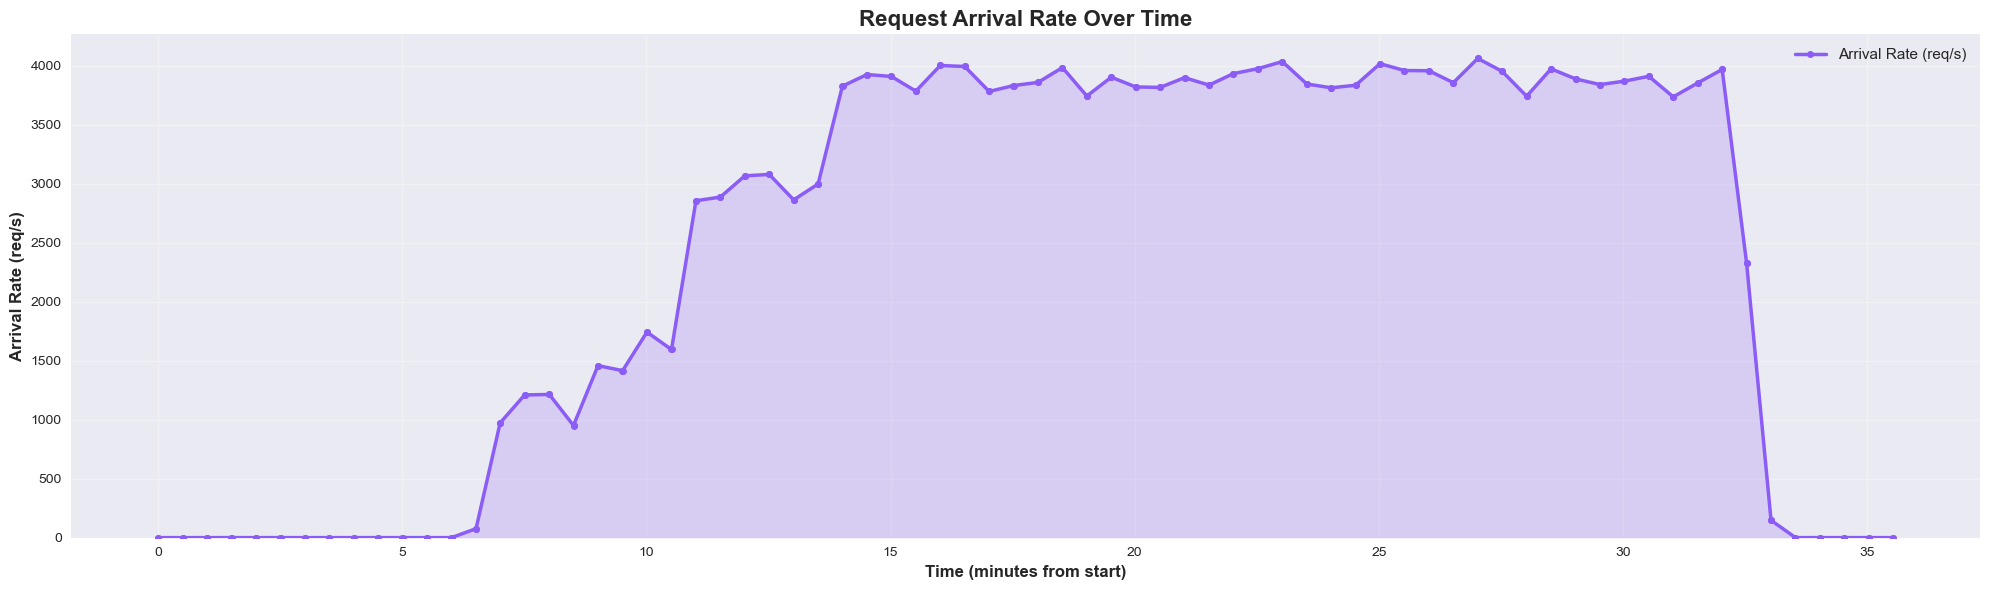

In [17]:
# Plot arrival rate over time
if len(df_arrival) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot arrival rate
    ax.plot(df_arrival['time_min'], df_arrival['arrival_rate'], 
            '-o', color='#8b5cf6', linewidth=2.5, markersize=5, label='Arrival Rate (req/s)')
    ax.fill_between(df_arrival['time_min'], 0, df_arrival['arrival_rate'], 
                     color='#8b5cf6', alpha=0.2)
    
    ax.set_xlabel('Time (minutes from start)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Arrival Rate (req/s)', fontsize=12, fontweight='bold')
    ax.set_title('Request Arrival Rate Over Time', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # Save plot
    output_file = plots_dir / 'arrival_rate.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"✓ Saved arrival rate plot to {output_file}")
    
    plt.show()
else:
    print("⚠ No arrival rate data to plot")

## 6.1 Arrival Rate (Load) Over Time

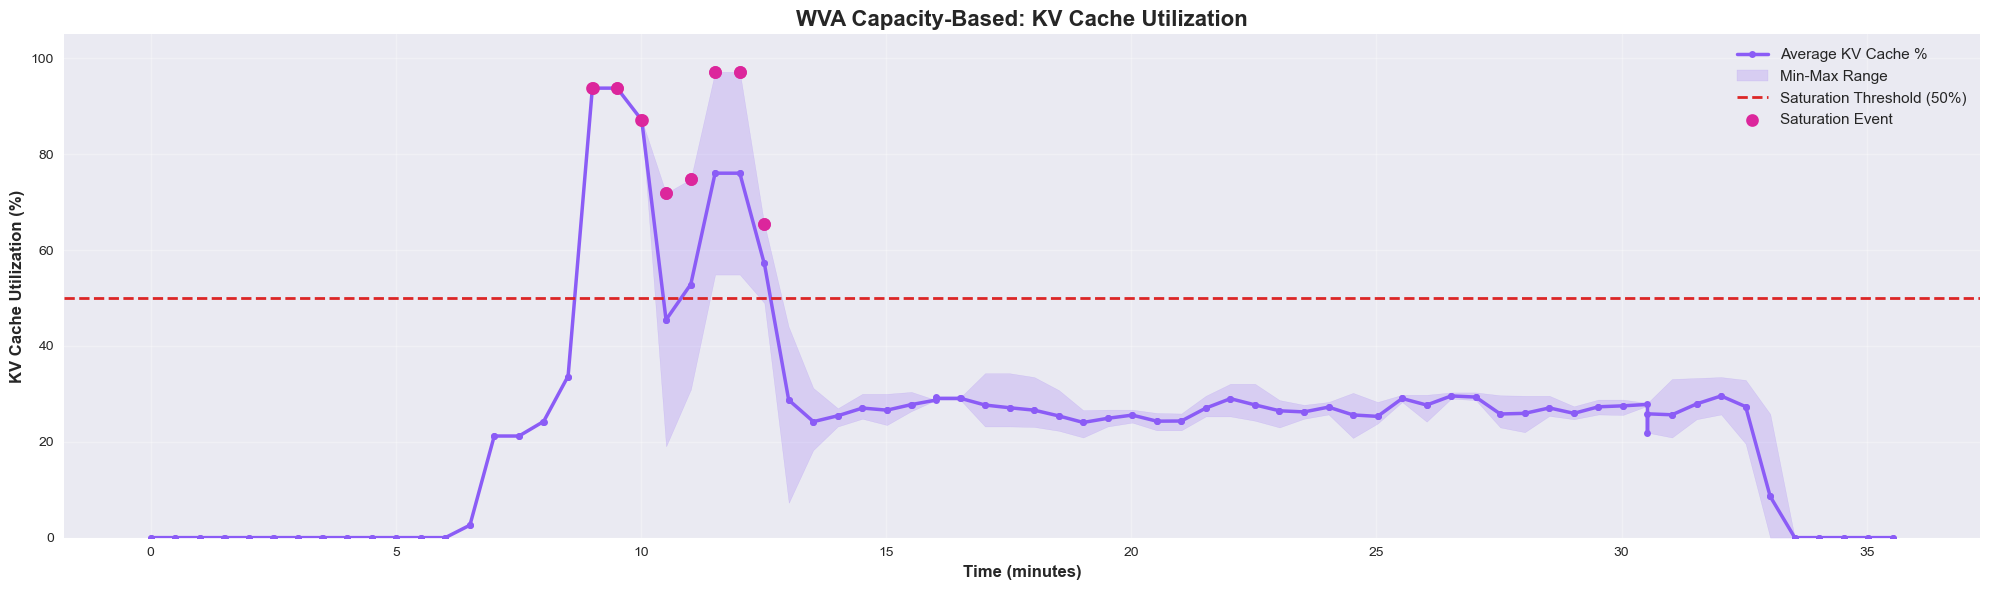

✅ KV cache plot complete


In [18]:
if len(df_kv_agg) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot KV cache metrics
    ax.plot(df_kv_agg['time_relative'], df_kv_agg['kv_pct_mean'], 
            '-o', color='#8b5cf6', label='Average KV Cache %', markersize=5, linewidth=2.5)
    ax.fill_between(df_kv_agg['time_relative'], 
                     df_kv_agg['kv_pct_min'], 
                     df_kv_agg['kv_pct_max'], 
                     alpha=0.2, color='#8b5cf6', label='Min-Max Range')
    
    # Add saturation threshold (from WVA configMap)
    ax.axhline(y=KV_CACHE_THRESHOLD*100, color='#dc2626', linestyle='--', 
               label=f'Saturation Threshold ({KV_CACHE_THRESHOLD*100:.0f}%)', linewidth=2)
    
    # Highlight saturation events
    saturated = df_kv_agg[df_kv_agg['kv_pct_max'] > KV_CACHE_THRESHOLD*100]
    if len(saturated) > 0:
        ax.scatter(saturated['time_relative'], saturated['kv_pct_max'], 
                   color="#dc269c", s=150, marker='.', linewidth=3, label='Saturation Event', zorder=5)
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('KV Cache Utilization (%)', fontsize=12, fontweight='bold')
    ax.set_title('WVA Capacity-Based: KV Cache Utilization', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'kv_cache_utilization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ KV cache plot complete")
else:
    print("⚠️  No KV cache data to plot")

## 7. Visualization: Queue Length

## 7.5 Visualization: Token Generation Latencies (TTFT & ITL)

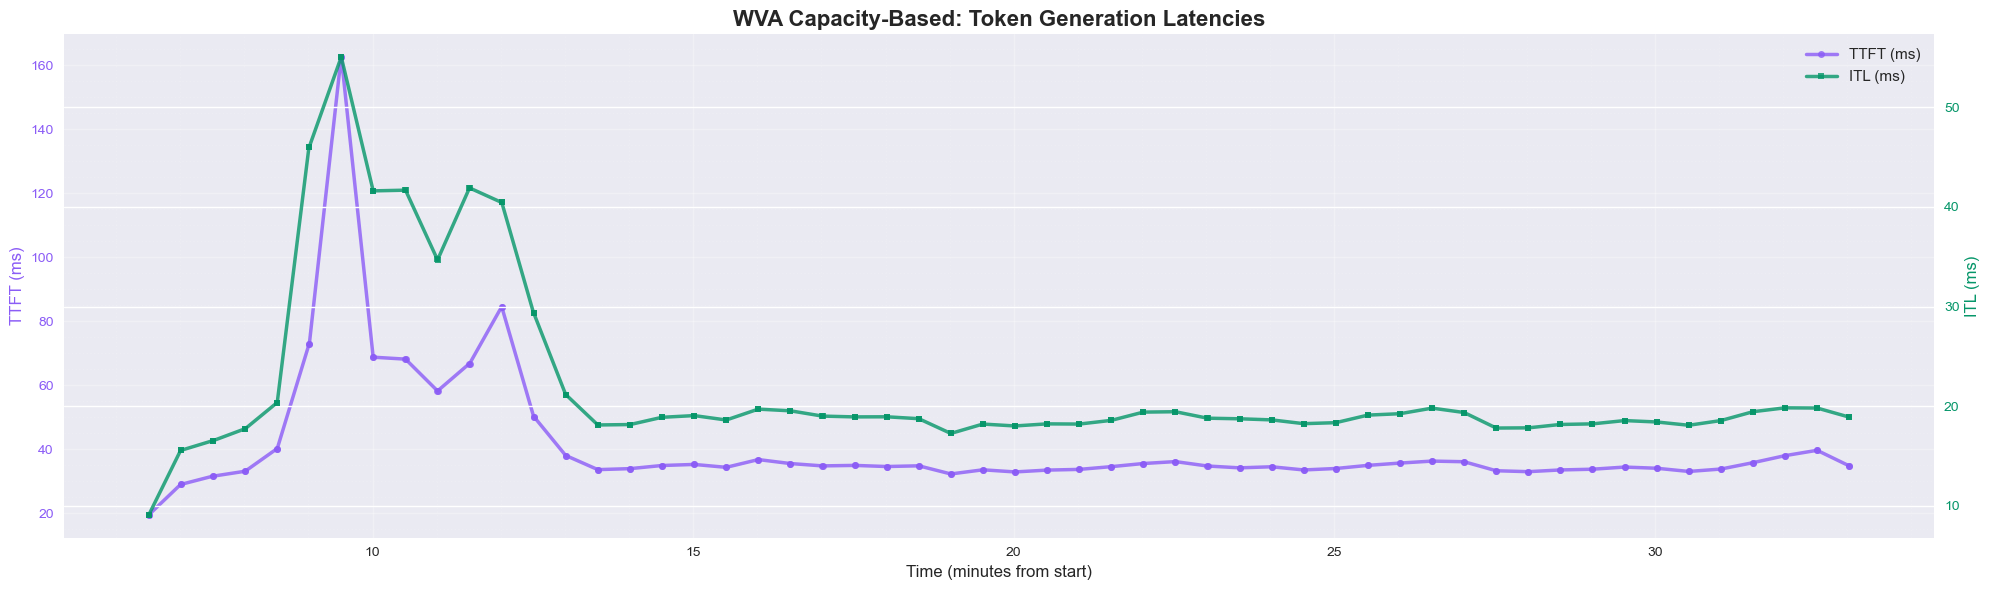

✅ TTFT/ITL plot complete


In [19]:
if len(df_metrics) > 0:
    # Check if we have any non-zero data
    has_ttft = (df_metrics['ttft'] > 0).any() if 'ttft' in df_metrics.columns else False
    has_itl = (df_metrics['itl'] > 0).any() if 'itl' in df_metrics.columns else False
    
    if has_ttft or has_itl:
        fig, ax = plt.subplots(figsize=(20, 6))
        
        # Create twin axis for different scales
        ax2 = ax.twinx()
        
        if has_ttft:
            ttft_mask = df_metrics['ttft'] > 0
            line1 = ax.plot(df_metrics['time_relative'][ttft_mask], df_metrics['ttft'][ttft_mask], 
                    label='TTFT (ms)', color='#8b5cf6', marker='o', linewidth=2.5, markersize=5, alpha=0.8)
            ax.set_ylabel('TTFT (ms)', fontsize=12, color='#8b5cf6')
            ax.tick_params(axis='y', labelcolor='#8b5cf6')
        
        if has_itl:
            itl_mask = df_metrics['itl'] > 0
            line2 = ax2.plot(df_metrics['time_relative'][itl_mask], df_metrics['itl'][itl_mask], 
                    label='ITL (ms)', color='#059669', marker='s', linewidth=2.5, markersize=4, alpha=0.8)
            ax2.set_ylabel('ITL (ms)', fontsize=12, color='#059669')
            ax2.tick_params(axis='y', labelcolor='#059669')
        
        ax.set_xlabel('Time (minutes from start)', fontsize=12)
        ax.set_title('WVA Capacity-Based: Token Generation Latencies', fontsize=16, fontweight='bold')
        
        # Combine legends
        if has_ttft and has_itl:
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='best', fontsize=11, framealpha=0.9)
        elif has_ttft:
            ax.legend(loc='best', fontsize=11, framealpha=0.9)
        else:
            ax2.legend(loc='best', fontsize=11, framealpha=0.9)
        
        ax.grid(True, which='major', alpha=0.3, linestyle='-')
        ax.grid(True, which='minor', alpha=0.15, linestyle=':')
        ax.minorticks_on()
        
        plt.tight_layout()
        plt.savefig(EXPERIMENT_DIR / 'plots' / 'latencies.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ TTFT/ITL plot complete")
    else:
        print("⚠️  No TTFT/ITL data collected (all zeros - metrics may not be available)")
else:
    print("⚠️  No metrics data to plot")

## 7.7 Visualization: Arrival Rate

In [20]:
if len(df_metrics) > 0 and 'arrival_rate' in df_metrics.columns:
    # Check if we have any non-zero arrival rate data
    has_arrival_rate = (df_metrics['arrival_rate'] > 0).any()
    
    if has_arrival_rate:
        fig, ax = plt.subplots(figsize=(20, 6))
        
        # Filter for non-zero values
        arrival_rate_mask = df_metrics['arrival_rate'] > 0
        arrival_rate_data = df_metrics[arrival_rate_mask]
        
        ax.plot(arrival_rate_data['time_relative'], arrival_rate_data['arrival_rate'], 
                '-', color='#06b6d4', linewidth=2.5, label='Arrival Rate')
        ax.fill_between(arrival_rate_data['time_relative'], 0, arrival_rate_data['arrival_rate'], 
                        color='#06b6d4', alpha=0.2)
        
        # Add mean line
        mean_arrival = arrival_rate_data['arrival_rate'].mean()
        ax.axhline(y=mean_arrival, color='#ea580c', linestyle='--', 
                   label=f'Mean: {mean_arrival:.2f} req/s', linewidth=2, zorder=5)
        
        ax.set_xlabel('Time (minutes from start)', fontsize=12)
        ax.set_ylabel('Arrival Rate (requests/second)', fontsize=12)
        ax.set_title('Request Arrival Rate Evolution', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=11, framealpha=0.9)
        ax.grid(True, which='both', alpha=0.3)
        ax.minorticks_on()
        ax.set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.savefig(EXPERIMENT_DIR / 'plots' / 'arrival_rate.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Arrival rate plot complete")
    else:
        print("⚠️  No arrival rate data collected (all zeros - workload may not have started)")
else:
    print("⚠️  No arrival rate data available")

⚠️  No arrival rate data available


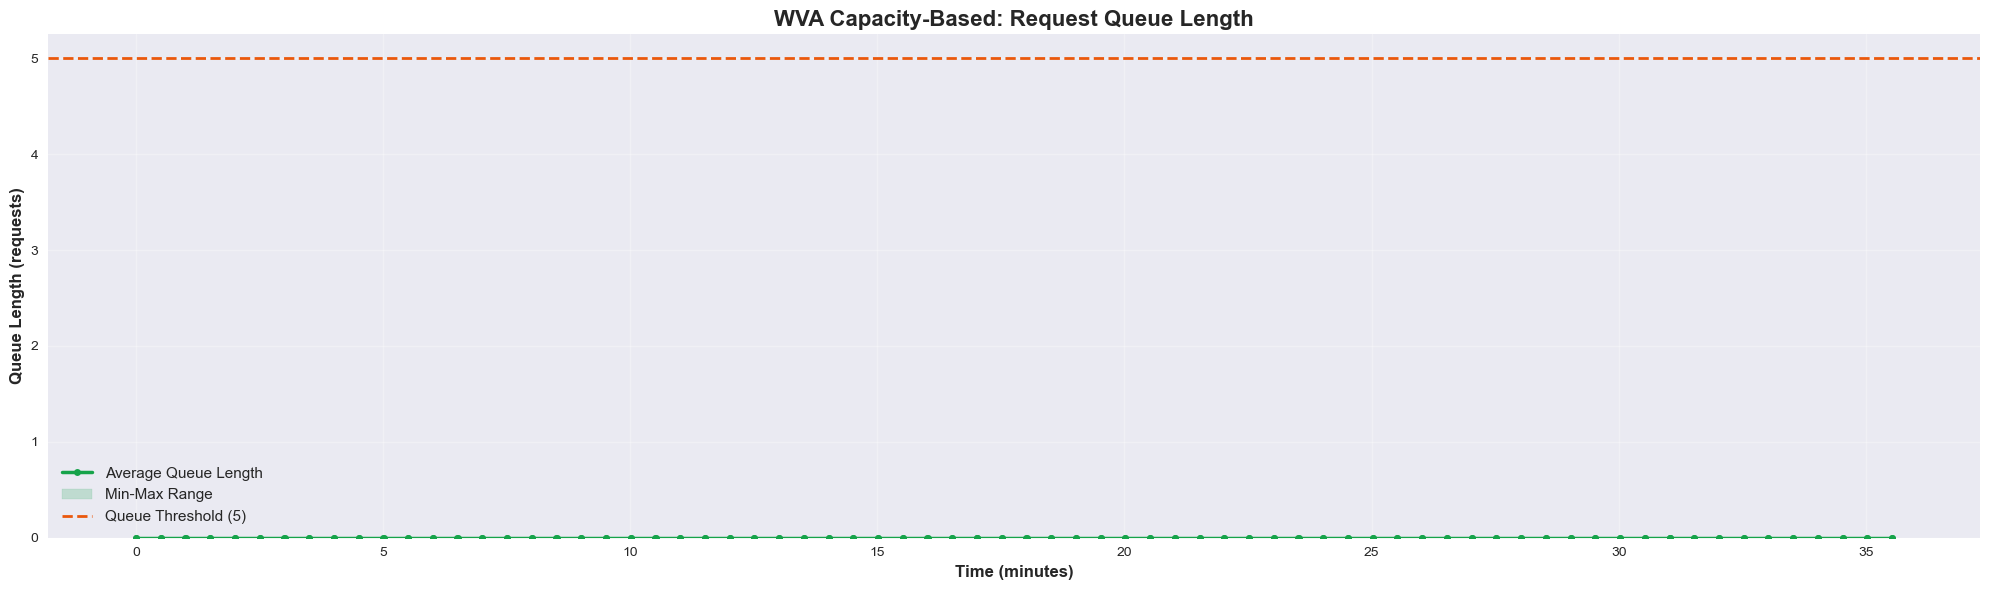

✅ Queue length plot complete


In [21]:
if len(df_queue_agg) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot queue metrics
    ax.plot(df_queue_agg['time_relative'], df_queue_agg['queue_mean'], 
            '-o', color='#16a34a', label='Average Queue Length', markersize=5, linewidth=2.5)
    ax.fill_between(df_queue_agg['time_relative'], 
                     df_queue_agg['queue_min'], 
                     df_queue_agg['queue_max'], 
                     alpha=0.2, color='#16a34a', label='Min-Max Range')
    
    # Add queue threshold (from WVA configMap)
    ax.axhline(y=QUEUE_LENGTH_THRESHOLD, color='#ea580c', linestyle='--', 
               label=f'Queue Threshold ({QUEUE_LENGTH_THRESHOLD})', linewidth=2)
    
    # Highlight queue buildup
    buildup = df_queue_agg[df_queue_agg['queue_max'] > QUEUE_LENGTH_THRESHOLD]
    if len(buildup) > 0:
        ax.scatter(buildup['time_relative'], buildup['queue_max'], 
                   color='#dc2626', s=150, marker='x', linewidth=3, label='Queue Buildup', zorder=5)
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Queue Length (requests)', fontsize=12, fontweight='bold')
    ax.set_title('WVA Capacity-Based: Request Queue Length', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'queue_length.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Queue length plot complete")
else:
    print("⚠️  No queue data to plot")

## 8. Visualization: Replica Scaling Over Time

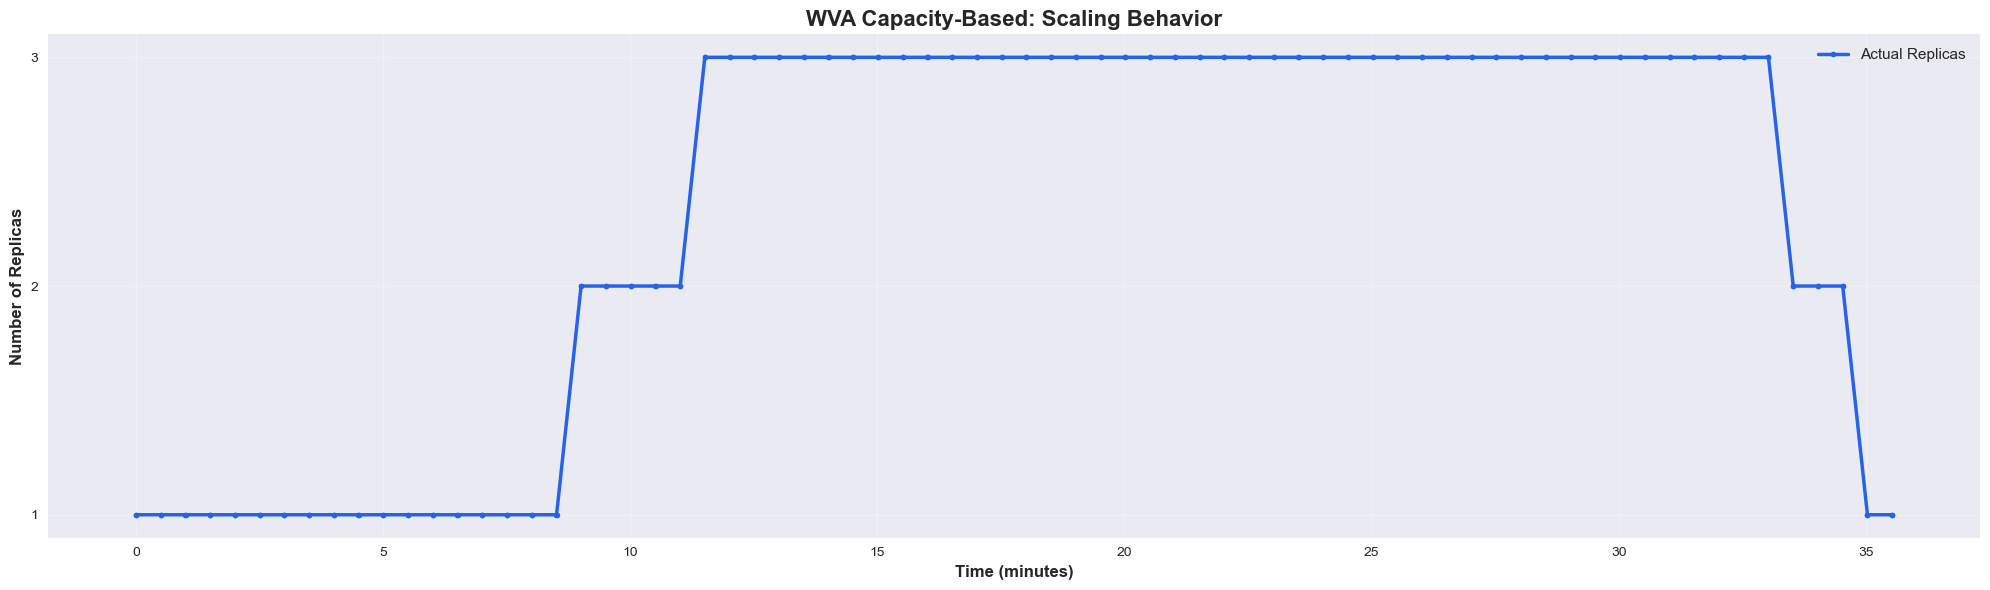

✅ Replica scaling plot complete


In [22]:
if len(df_metrics) > 0 or len(df_scaling) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot actual replicas from metrics (shows when replicas are truly ready)
    if len(df_metrics) > 0 and 'replicas' in df_metrics.columns:
        ax.plot(df_metrics['time_relative'], df_metrics['replicas'], 
                label='Actual Replicas', marker='o', linewidth=2.5, markersize=4, 
                color='#2563eb', zorder=3)
    
    # Add vertical lines at scaling decision times
#     if len(df_scaling) > 0:
#         scale_up = df_scaling[df_scaling['action'] == 'scale-up']
#         scale_down = df_scaling[df_scaling['action'] == 'scale-down']
        
#         if len(scale_up) > 0:
#             for _, event in scale_up.iterrows():
#                 ax.axvline(x=event['time_relative'], color='#16a34a', linestyle='--', 
#                           alpha=0.7, linewidth=2, label='Scale Up Decision' if _ == scale_up.index[0] else '')
#                 ax.text(event['time_relative'], ax.get_ylim()[1] * 0.95, 
#                        f"↑ {event['current_replicas']}→{event['target_replicas']}", 
#                        rotation=0, ha='center', va='top', fontsize=10, 
#                        color='darkgreen', fontweight='bold',
#                        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.8))
        
#         if len(scale_down) > 0:
#             for _, event in scale_down.iterrows():
#                 ax.axvline(x=event['time_relative'], color='#ea580c', linestyle='--', 
#                           alpha=0.7, linewidth=2, label='Scale Down Decision' if _ == scale_down.index[0] else '')
#                 ax.text(event['time_relative'], ax.get_ylim()[1] * 0.05, 
#                        f"↓ {event['current_replicas']}→{event['target_replicas']}", 
#                        rotation=0, ha='center', va='bottom', fontsize=10, 
#                        color='darkorange', fontweight='bold',
#                        bbox=dict(boxstyle='round,pad=0.4', facecolor='bisque', alpha=0.8))
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Replicas', fontsize=12, fontweight='bold')
    ax.set_title('WVA Capacity-Based: Scaling Behavior', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'replica_scaling.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Replica scaling plot complete")
else:
    print("⚠️  No scaling data to plot")

## 8.3 Visualization: Scaling Decisions with Queue Context

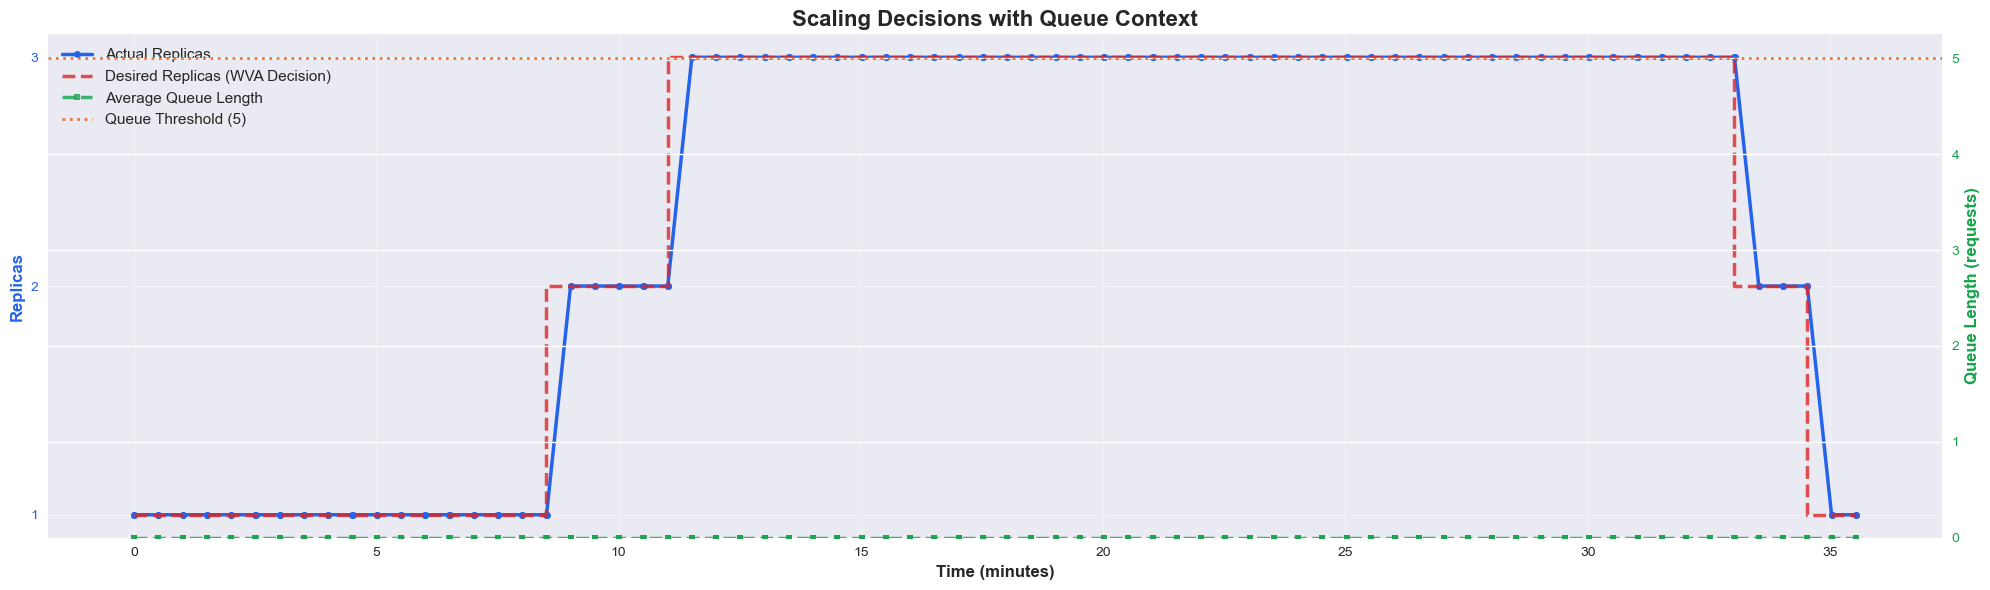

✅ Scaling decisions with queue context plot complete


In [23]:
if len(df_metrics) > 0 and len(df_queue_agg) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Create twin axis
    ax2 = ax.twinx()
    
    # Plot actual replicas on left axis (blue)
    ax.plot(df_metrics['time_relative'], df_metrics['replicas'], 
            '-o', label='Actual Replicas', markersize=5, linewidth=2.5, color='#2563eb')
    
    # Plot desired replicas (from scaling decisions) if enabled and available
    if SHOW_DESIRED_REPLICAS and len(df_scaling) > 0 and 'target_replicas' in df_scaling.columns:
        # Use step plot for sparse scaling decision data
        ax.step(df_scaling['time_relative'], df_scaling['target_replicas'], 
                where='post', label='Desired Replicas (WVA Decision)', 
                linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
    
    # Plot queue length on right axis (green)
    ax2.plot(df_queue_agg['time_relative'], df_queue_agg['queue_mean'], 
             '--s', color='#16a34a', label='Average Queue Length', markersize=5, linewidth=2.5, alpha=0.8)
    
    # Add queue threshold on right axis
    ax2.axhline(y=QUEUE_LENGTH_THRESHOLD, color='#ea580c', linestyle=':', 
                label=f'Queue Threshold ({QUEUE_LENGTH_THRESHOLD})', linewidth=2, alpha=0.8)
    
    # Color-code axes labels to match plots
    ax.set_ylabel('Replicas', fontsize=12, fontweight='bold', color='#2563eb')
    ax.tick_params(axis='y', labelcolor='#2563eb')
    
    ax2.set_ylabel('Queue Length (requests)', fontsize=12, fontweight='bold', color='#16a34a')
    ax2.tick_params(axis='y', labelcolor='#16a34a')
    
    ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_title('Scaling Decisions with Queue Context', fontsize=16, fontweight='bold')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)
    
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'scaling_queue_context.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Scaling decisions with queue context plot complete")
else:
    print("⚠️  Missing data for scaling/queue context plot")

## 8.5 Combined Summary View

All key metrics in a single multi-panel overview for comparison.


📊 Generating combined summary plot...


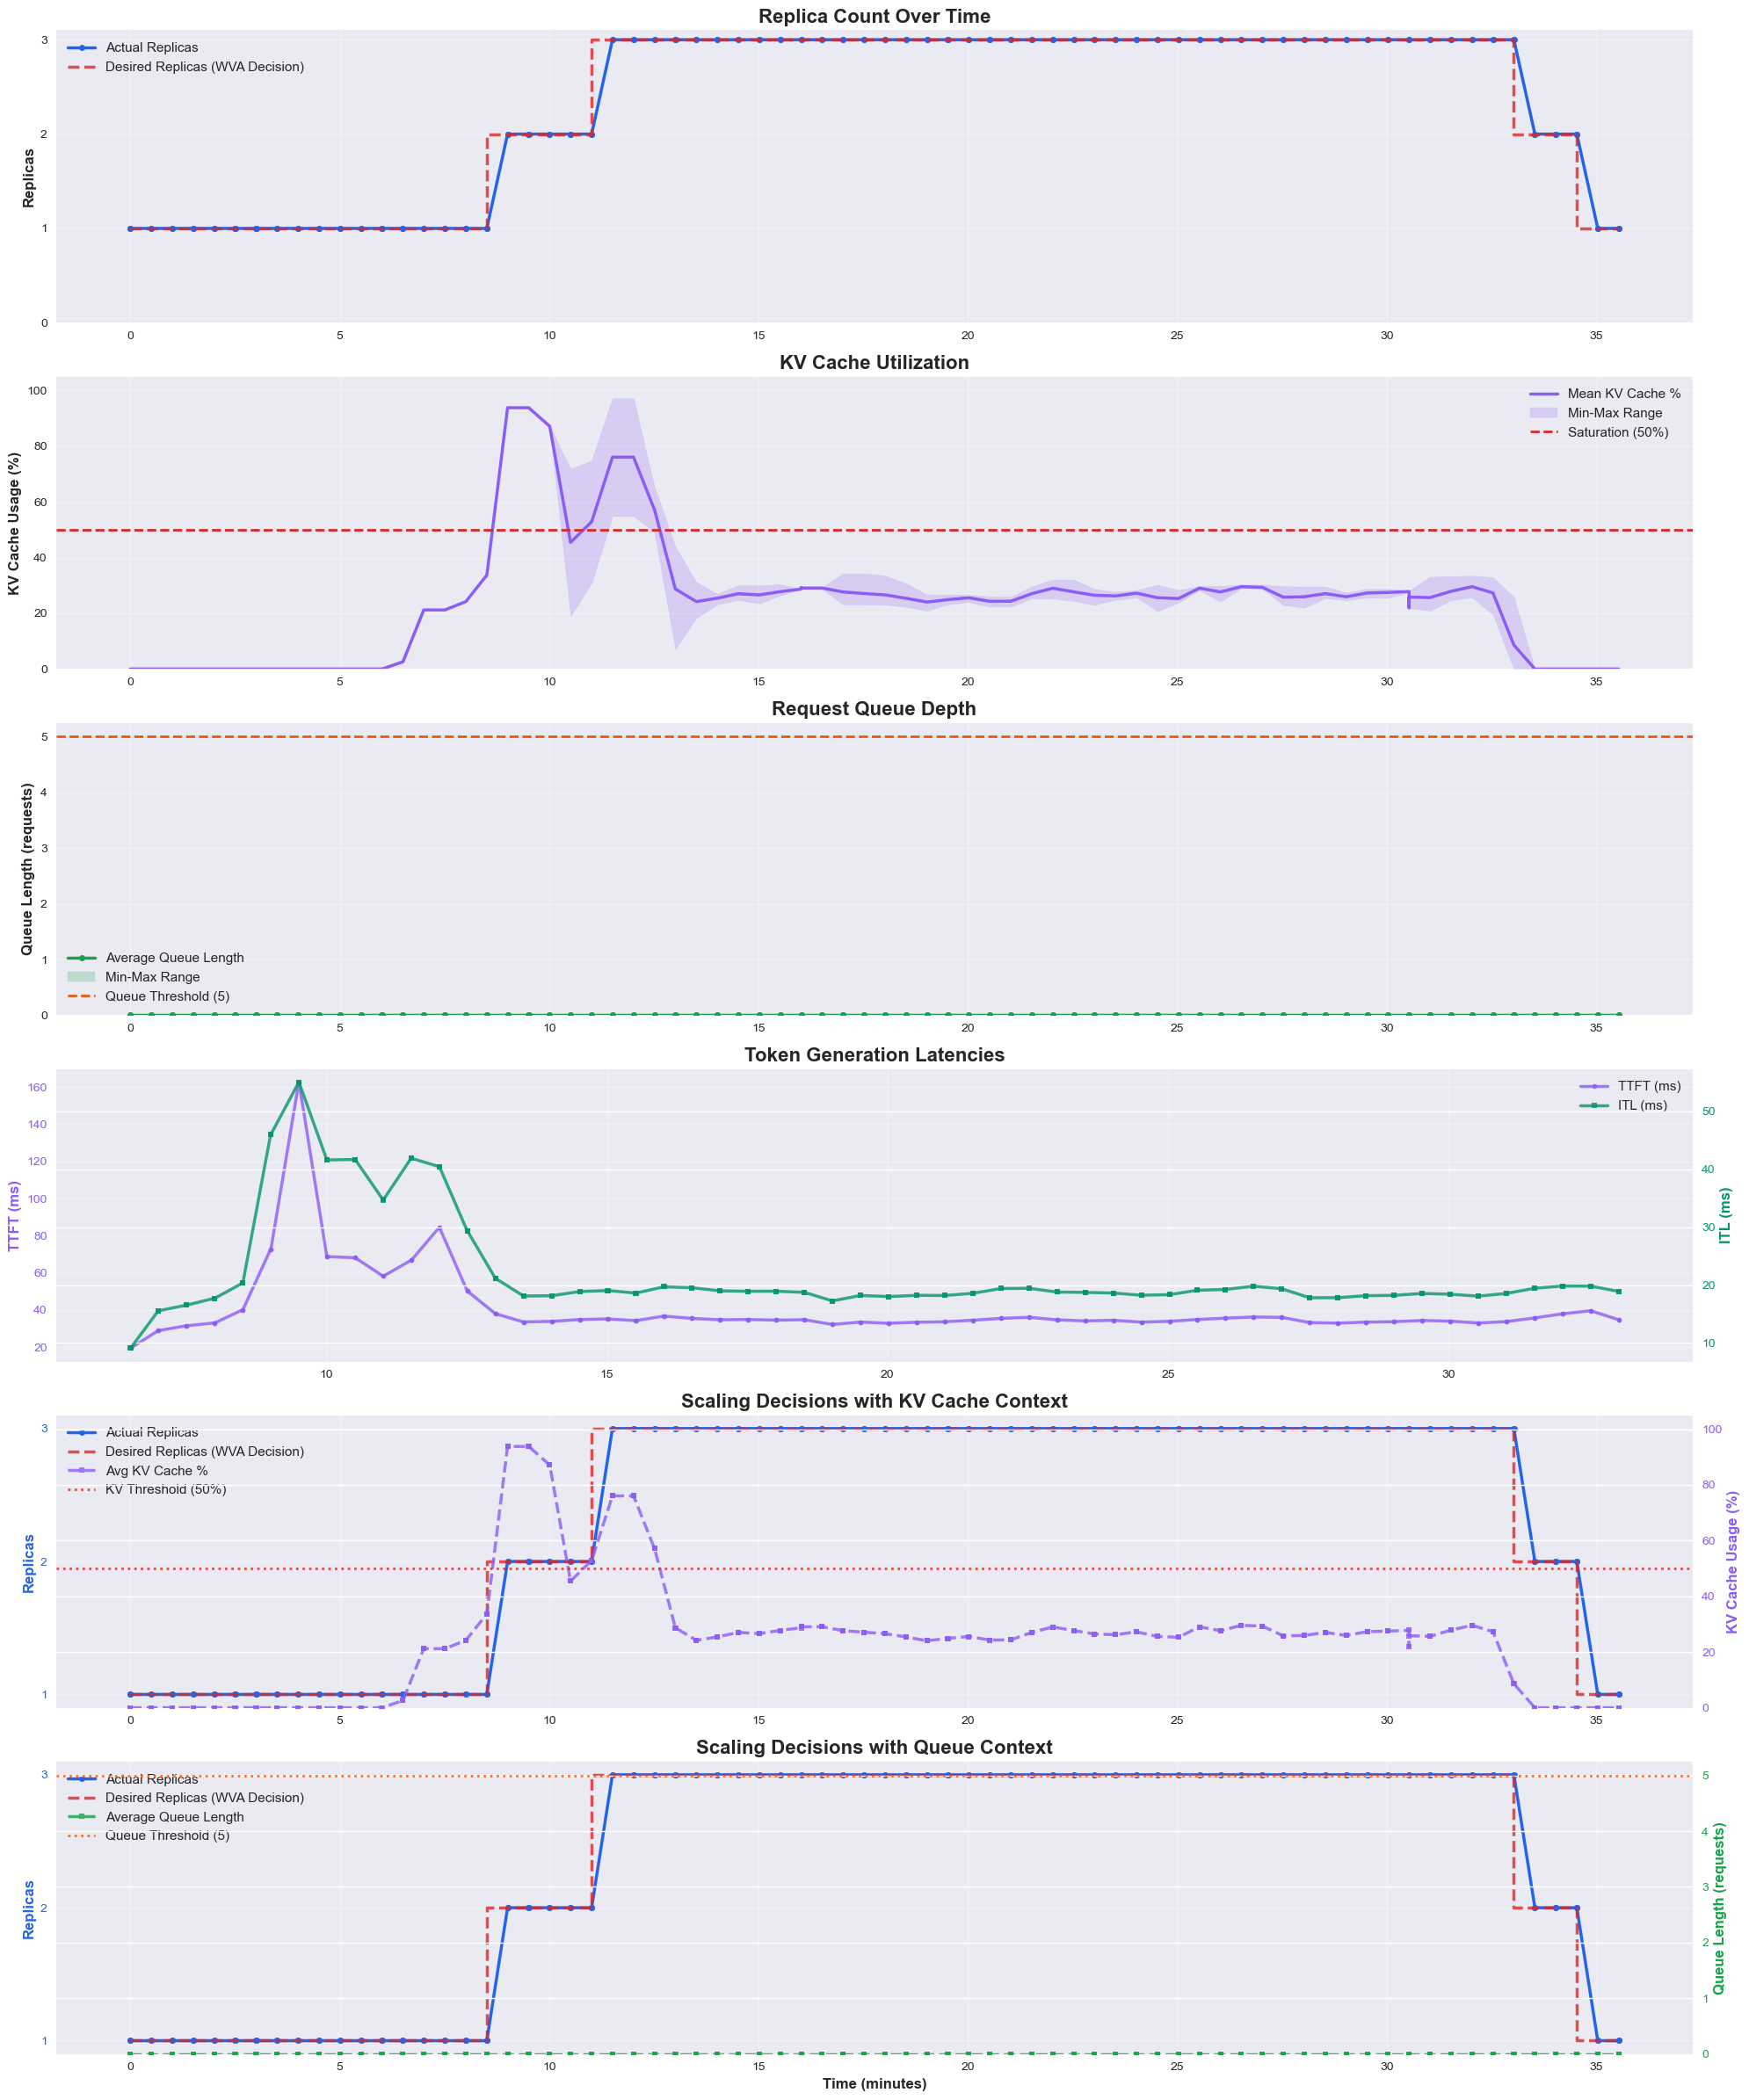

✅ Combined summary plot complete


In [24]:
# 8. Combined Summary Plot (All Metrics Over Time)
print("\n📊 Generating combined summary plot...")

# Determine which plots to create based on available data
plots_to_create = []

# Check for replicas data
if len(df_metrics) > 0 and 'replicas' in df_metrics.columns:
    plots_to_create.append('replicas')

# Check for KV cache data
if len(df_kv_agg) > 0:
    plots_to_create.append('kv_cache')

# Check for queue data
if len(df_queue_agg) > 0:
    plots_to_create.append('queue')

# Check for latency data
has_ttft = len(df_metrics) > 0 and 'ttft' in df_metrics.columns and df_metrics['ttft'].notna().any()
has_itl = len(df_metrics) > 0 and 'itl' in df_metrics.columns and df_metrics['itl'].notna().any()
if has_ttft or has_itl:
    plots_to_create.append('latencies')

# Check for arrival rate
if len(df_metrics) > 0 and 'arrival_rate' in df_metrics.columns and df_metrics['arrival_rate'].notna().any():
    plots_to_create.append('arrival_rate')

# Contextual scaling panels
if len(df_metrics) > 0 and 'replicas' in df_metrics.columns and len(df_kv_agg) > 0:
    plots_to_create.append('scaling_kv_context')

if len(df_metrics) > 0 and 'replicas' in df_metrics.columns and len(df_queue_agg) > 0:
    plots_to_create.append('scaling_queue_context')

num_plots = len(plots_to_create)

if num_plots == 0:
    print("⚠️ No data available for combined plot")
else:
    # Create subplots with modern sizing
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 4*num_plots))
    
    # Handle single subplot case
    if num_plots == 1:
        axes = [axes]
    
    current_plot = 0
    
    # Panel 1: Replicas (Actual vs Desired)
    if 'replicas' in plots_to_create:
        ax = axes[current_plot]
        
        # Plot actual replicas
        ax.plot(df_metrics['time_relative'], df_metrics['replicas'], 
                '-o', color='#2563eb', label='Actual Replicas', markersize=5, linewidth=2.5)
        
        # Plot desired replicas if enabled and available
        if SHOW_DESIRED_REPLICAS and len(df_scaling) > 0 and 'target_replicas' in df_scaling.columns:
            # Use step plot for sparse scaling decision data
            ax.step(df_scaling['time_relative'], df_scaling['target_replicas'], 
                    where='post', label='Desired Replicas (WVA Decision)', 
                    linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
        
        ax.set_ylabel('Replicas', fontsize=12, fontweight='bold')
        ax.set_title('Replica Count Over Time', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.set_ylim(bottom=0)
        current_plot += 1
    
    # Panel 2: KV Cache Utilization
    if 'kv_cache' in plots_to_create:
        ax = axes[current_plot]
        
        # Plot mean KV cache percentage
        ax.plot(df_kv_agg['time_relative'], df_kv_agg['kv_pct_mean'], 
                '-', color='#8b5cf6', label='Mean KV Cache %', linewidth=2.5)
        
        # Add min/max shaded area
        ax.fill_between(df_kv_agg['time_relative'], 
                         df_kv_agg['kv_pct_min'], 
                         df_kv_agg['kv_pct_max'], 
                         alpha=0.2, color='#8b5cf6', label='Min-Max Range')
        
        # Add threshold line
        ax.axhline(y=KV_CACHE_THRESHOLD*100, color='#dc2626', linestyle='--', 
                   label=f'Saturation ({KV_CACHE_THRESHOLD*100:.0f}%)', linewidth=2)
        
        ax.set_ylabel('KV Cache Usage (%)', fontsize=12, fontweight='bold')
        ax.set_title('KV Cache Utilization', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)
        current_plot += 1
    
    # Panel 3: Queue Length
    if 'queue' in plots_to_create:
        ax = axes[current_plot]
        
        ax.plot(df_queue_agg['time_relative'], df_queue_agg['queue_mean'], 
                '-o', color='#16a34a', label='Average Queue Length', markersize=5, linewidth=2.5)
        ax.fill_between(df_queue_agg['time_relative'], 
                         df_queue_agg['queue_min'], 
                         df_queue_agg['queue_max'], 
                         alpha=0.2, color='#16a34a', label='Min-Max Range')
        
        ax.axhline(y=QUEUE_LENGTH_THRESHOLD, color='#ea580c', linestyle='--', 
                   label=f'Queue Threshold ({QUEUE_LENGTH_THRESHOLD})', linewidth=2)
        
        ax.set_ylabel('Queue Length (requests)', fontsize=12, fontweight='bold')
        ax.set_title('Request Queue Depth', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
        current_plot += 1
    
    # Panel 4: TTFT/ITL Latencies
    if 'latencies' in plots_to_create:
        ax = axes[current_plot]
        ax2 = ax.twinx()
        
        if has_ttft:
            ttft_mask = df_metrics['ttft'] > 0
            line1 = ax.plot(df_metrics['time_relative'][ttft_mask], df_metrics['ttft'][ttft_mask], 
                    label='TTFT (ms)', color='#8b5cf6', marker='o', linewidth=2.5, markersize=4, alpha=0.8)
            ax.set_ylabel('TTFT (ms)', fontsize=12, fontweight='bold', color='#8b5cf6')
            ax.tick_params(axis='y', labelcolor='#8b5cf6')
        
        if has_itl:
            itl_mask = df_metrics['itl'] > 0
            line2 = ax2.plot(df_metrics['time_relative'][itl_mask], df_metrics['itl'][itl_mask], 
                    label='ITL (ms)', color='#059669', marker='s', linewidth=2.5, markersize=4, alpha=0.8)
            ax2.set_ylabel('ITL (ms)', fontsize=12, fontweight='bold', color='#059669')
            ax2.tick_params(axis='y', labelcolor='#059669')
        
        ax.set_title('Token Generation Latencies', fontsize=16, fontweight='bold')
        
        # Combine legends
        if has_ttft and has_itl:
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='best', fontsize=11, framealpha=0.9)
        elif has_ttft:
            ax.legend(loc='best', fontsize=11, framealpha=0.9)
        else:
            ax2.legend(loc='best', fontsize=11, framealpha=0.9)
        
        ax.grid(True, alpha=0.3)
        current_plot += 1
    
    # Panel 5: Arrival Rate
    if 'arrival_rate' in plots_to_create:
        ax = axes[current_plot]
        
        arrival_rate_mask = df_metrics['arrival_rate'] > 0
        ax.plot(df_metrics['time_relative'][arrival_rate_mask], 
                df_metrics['arrival_rate'][arrival_rate_mask], 
                label='Arrival Rate (req/s)', color='#06b6d4', marker='o', 
                linewidth=2.5, markersize=4, alpha=0.8)
        
        # Add mean line
        mean_arrival = df_metrics['arrival_rate'][arrival_rate_mask].mean()
        ax.axhline(y=mean_arrival, color='#ea580c', linestyle='--', 
                   label=f'Mean: {mean_arrival:.2f} req/s', linewidth=2, alpha=0.8)
        
        ax.set_ylabel('Arrival Rate (req/s)', fontsize=12, fontweight='bold')
        ax.set_title('Request Arrival Rate', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
        current_plot += 1
    
    # Panel 6: Scaling with KV Context
    if 'scaling_kv_context' in plots_to_create:
        ax = axes[current_plot]
        ax2 = ax.twinx()
        
        # Plot actual replicas on left axis (blue)
        ax.plot(df_metrics['time_relative'], df_metrics['replicas'], 
                '-o', color='#2563eb', label='Actual Replicas', markersize=5, linewidth=2.5)
        
        # Plot desired replicas if enabled and available
        if SHOW_DESIRED_REPLICAS and len(df_scaling) > 0 and 'target_replicas' in df_scaling.columns:
            # Use step plot for sparse scaling decision data
            ax.step(df_scaling['time_relative'], df_scaling['target_replicas'], 
                    where='post', label='Desired Replicas (WVA Decision)', 
                    linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
        
        # Plot KV cache on right axis (purple)
        ax2.plot(df_kv_agg['time_relative'], df_kv_agg['kv_pct_mean'], 
                 color='#8b5cf6', linestyle='--', marker='s', label='Avg KV Cache %', 
                 markersize=5, linewidth=2.5, alpha=0.8)
        
        # Add KV threshold on right axis
        ax2.axhline(y=KV_CACHE_THRESHOLD*100, color='#dc2626', linestyle=':', 
                    label=f'KV Threshold ({KV_CACHE_THRESHOLD*100:.0f}%)', linewidth=2, alpha=0.8)
        
        # Color-code axes labels to match plots
        ax.set_ylabel('Replicas', fontsize=12, fontweight='bold', color='#2563eb')
        ax.tick_params(axis='y', labelcolor='#2563eb')
        
        ax2.set_ylabel('KV Cache Usage (%)', fontsize=12, fontweight='bold', color='#8b5cf6')
        ax2.tick_params(axis='y', labelcolor='#8b5cf6')
        
        ax.set_title('Scaling Decisions with KV Cache Context', fontsize=16, fontweight='bold')
        
        # Combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)
        
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.set_ylim(0, 105)
        current_plot += 1
    
    # Panel 7: Scaling with Queue Context
    if 'scaling_queue_context' in plots_to_create:
        ax = axes[current_plot]
        ax2 = ax.twinx()
        
        # Plot actual replicas on left axis (blue)
        ax.plot(df_metrics['time_relative'], df_metrics['replicas'], 
                '-o', color='#2563eb', label='Actual Replicas', markersize=5, linewidth=2.5)
        
        # Plot desired replicas if enabled and available
        if SHOW_DESIRED_REPLICAS and len(df_scaling) > 0 and 'target_replicas' in df_scaling.columns:
            # Use step plot for sparse scaling decision data
            ax.step(df_scaling['time_relative'], df_scaling['target_replicas'], 
                    where='post', label='Desired Replicas (WVA Decision)', 
                    linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
        
        # Plot queue length on right axis (green)
        ax2.plot(df_queue_agg['time_relative'], df_queue_agg['queue_mean'], 
                 color='#16a34a', linestyle='--', marker='s', label='Average Queue Length', 
                 markersize=5, linewidth=2.5, alpha=0.8)
        
        # Add queue threshold on right axis
        ax2.axhline(y=QUEUE_LENGTH_THRESHOLD, color='#ea580c', linestyle=':', 
                    label=f'Queue Threshold ({QUEUE_LENGTH_THRESHOLD})', linewidth=2, alpha=0.8)
        
        # Color-code axes labels to match plots
        ax.set_ylabel('Replicas', fontsize=12, fontweight='bold', color='#2563eb')
        ax.tick_params(axis='y', labelcolor='#2563eb')
        
        ax2.set_ylabel('Queue Length (requests)', fontsize=12, fontweight='bold', color='#16a34a')
        ax2.tick_params(axis='y', labelcolor='#16a34a')
        
        ax.set_title('Scaling Decisions with Queue Context', fontsize=16, fontweight='bold')
        
        # Combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)
        
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.set_ylim(bottom=0)
        current_plot += 1
    
    # Add shared x-label on bottom plot
    axes[-1].set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'combined_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Combined summary plot complete")

## 9. Scaling Events Details

View detailed information about each scaling decision.

In [25]:
if len(df_scaling) > 0:
    print("="*70)
    print(f"SCALING EVENTS ({len(df_scaling)} total)")
    print("="*70)
    print()
    
    for i, row in df_scaling.iterrows():
        print(f"Event {i+1}:")
        print("-" * 70)
        print(f"Timestamp:        {row['timestamp']}")
        print(f"Current Replicas: {row['current_replicas']}")
        print(f"Target Replicas:  {row['target_replicas']}")
        print(f"Action:           {row['action']}")
        
        # Show reason if available
        if 'reason' in row and pd.notna(row['reason']):
            print(f"Reason:           {row['reason']}")
        
        # Calculate time from start
        if 'time_relative' in row and pd.notna(row['time_relative']):
            print(f"Time (minutes):   {row['time_relative']:.2f}")
        
        print()
else:
    print("No scaling events detected in this experiment.")
    print("\nNote: Scaling decisions are logged when WVA makes a scaling action.")
    print("If the workload is stable and within capacity, no scaling may occur.")


SCALING EVENTS (144 total)

Event 1:
----------------------------------------------------------------------
Timestamp:        2025-11-28 20:51:51.711000+00:00
Current Replicas: 1
Target Replicas:  1
Action:           no-change
Reason:           capacity-only mode: no-change
Time (minutes):   0.00

Event 2:
----------------------------------------------------------------------
Timestamp:        2025-11-28 20:51:51.808000+00:00
Current Replicas: 1
Target Replicas:  1
Action:           no-change
Reason:           capacity-only mode: no-change
Time (minutes):   0.00

Event 3:
----------------------------------------------------------------------
Timestamp:        2025-11-28 20:52:21.731000+00:00
Current Replicas: 1
Target Replicas:  1
Action:           no-change
Reason:           capacity-only mode: no-change
Time (minutes):   0.50

Event 4:
----------------------------------------------------------------------
Timestamp:        2025-11-28 20:52:22.035000+00:00
Current Replicas: 1
Target R

## 10. Visualization: Per-Pod KV Cache Timeline

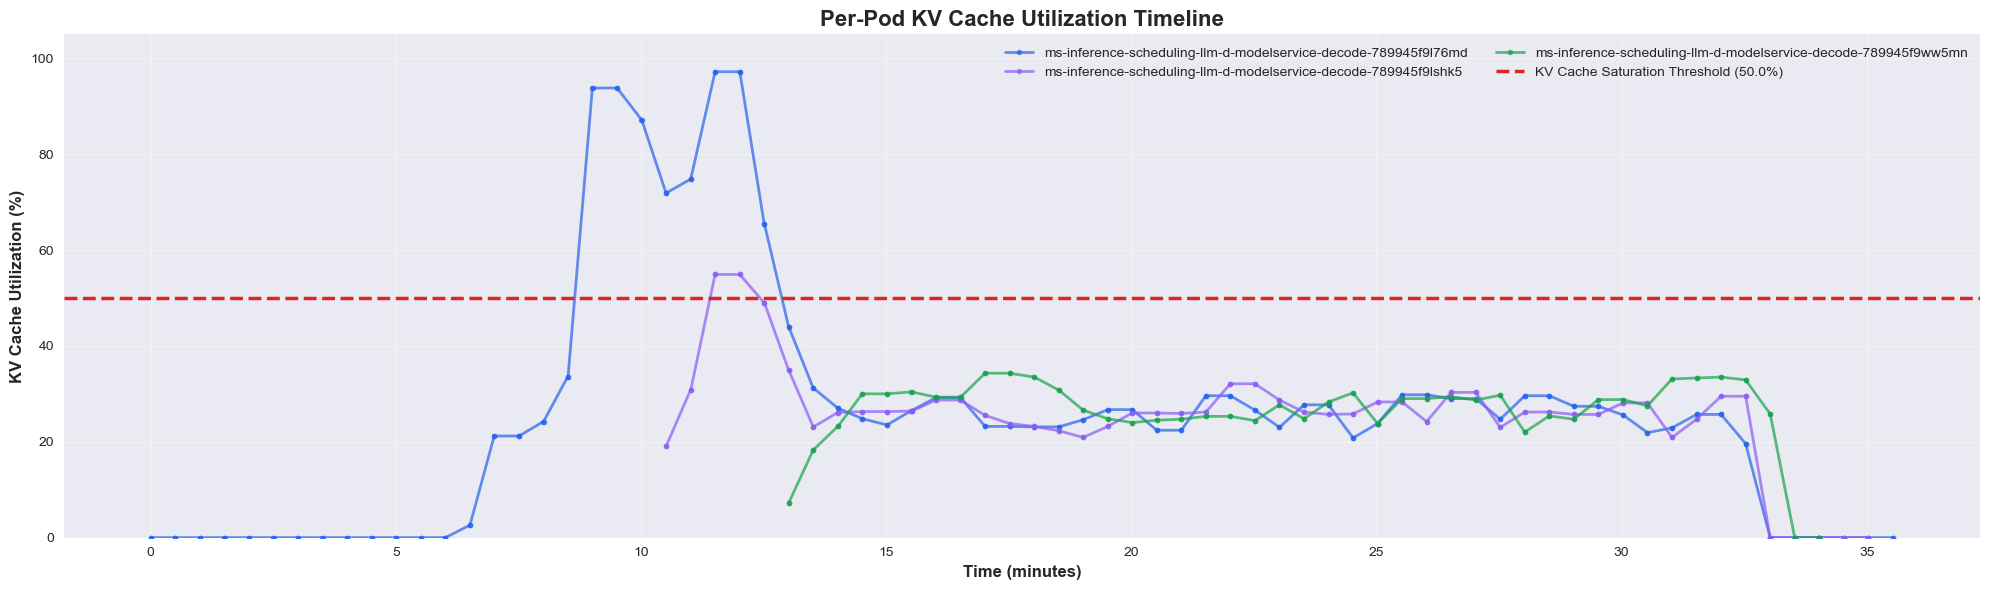

✅ Per-pod KV cache plot complete


In [26]:
if len(df_kv_cache) > 0:
    # Get unique pods
    pods = df_kv_cache['pod'].unique()
    
    if len(pods) <= 10:  # Only plot if reasonable number of pods
        fig, ax = plt.subplots(figsize=(20, 6))
        
        start_time = df_kv_cache['timestamp'].min()
        
        # Plot each pod with different colors
        colors = ['#2563eb', '#8b5cf6', '#16a34a', '#ea580c', '#06b6d4', 
                  '#dc2626', '#7c3aed', '#059669', '#f59e0b', '#ec4899']
        
        for i, pod in enumerate(pods):
            pod_data = df_kv_cache[df_kv_cache['pod'] == pod].copy()
            pod_data['time_relative'] = (pod_data['timestamp'] - start_time).dt.total_seconds() / 60
            pod_data = pod_data.sort_values('time_relative')
            
            ax.plot(pod_data['time_relative'], pod_data['kv_cache_pct'], 
                    '-o', label=pod, markersize=4, linewidth=2, alpha=0.7,
                    color=colors[i % len(colors)])
        
        ax.axhline(y=KV_CACHE_THRESHOLD*100, color='#dc2626', linestyle='--', 
                   label=f'KV Cache Saturation Threshold ({KV_CACHE_THRESHOLD*100}%)', 
                   linewidth=2.5, zorder=10)
        
        ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
        ax.set_ylabel('KV Cache Utilization (%)', fontsize=12, fontweight='bold')
        ax.set_title('Per-Pod KV Cache Utilization Timeline', fontsize=16, fontweight='bold')
        ax.legend(loc='best', fontsize=10, ncol=2, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)
        
        plt.tight_layout()
        plt.savefig(EXPERIMENT_DIR / 'plots' / 'per_pod_kv_cache.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Per-pod KV cache plot complete")
    else:
        print(f"⚠️  Too many pods ({len(pods)}) to plot individual timelines")
else:
    print("⚠️  No per-pod KV cache data to plot")

## 11. Export Processed Data

In [27]:
# Save aggregated metrics
output_files = []

if len(df_kv_agg) > 0:
    output_file = EXPERIMENT_DIR / 'kv_cache_aggregated.csv'
    df_kv_agg.to_csv(output_file, index=False)
    output_files.append(output_file.name)
    print(f"✓ Saved aggregated KV cache data to: {output_file}")

if len(df_queue_agg) > 0:
    output_file = EXPERIMENT_DIR / 'queue_aggregated.csv'
    df_queue_agg.to_csv(output_file, index=False)
    output_files.append(output_file.name)
    print(f"✓ Saved aggregated queue data to: {output_file}")

if len(df_capacity) > 0:
    output_file = EXPERIMENT_DIR / 'capacity_analysis.csv'
    df_capacity.to_csv(output_file, index=False)
    output_files.append(output_file.name)
    print(f"✓ Saved capacity analysis to: {output_file}")

# Create summary report
summary_file = EXPERIMENT_DIR / 'ANALYSIS_SUMMARY.md'

with open(summary_file, 'w') as f:
    f.write(f"# WVA Capacity-Based Experiment Analysis\n\n")
    f.write(f"**Experiment:** {EXPERIMENT_DIR.name}\n\n")
    f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"---\n\n")
    
    f.write(f"## Summary Statistics\n\n")
    f.write(f"- **KV Cache Measurements:** {len(df_kv_cache)}\n")
    f.write(f"- **Queue Measurements:** {len(df_queue)}\n")
    f.write(f"- **Capacity Analyses:** {len(df_capacity)}\n")
    f.write(f"- **Scaling Decisions:** {len(df_scaling)}\n\n")
    
    if len(df_kv_agg) > 0:
        SATURATION_THRESHOLD = 90.0
        saturated_count = (df_kv_agg['kv_pct_max'] > SATURATION_THRESHOLD).sum()
        saturated_pct = (saturated_count / len(df_kv_agg)) * 100
        
        f.write(f"## KV Cache Utilization\n\n")
        f.write(f"- Average: {df_kv_agg['kv_pct_mean'].mean():.1f}%\n")
        f.write(f"- Peak: {df_kv_agg['kv_pct_max'].max():.1f}%\n")
        f.write(f"- Min: {df_kv_agg['kv_pct_min'].min():.1f}%\n")
        f.write(f"- Saturation Events (>{SATURATION_THRESHOLD}%): {saturated_count}/{len(df_kv_agg)} ({saturated_pct:.1f}%)\n\n")
    
    if len(df_queue_agg) > 0:
        f.write(f"## Queue Length\n\n")
        f.write(f"- Average: {df_queue_agg['queue_mean'].mean():.1f} requests\n")
        f.write(f"- Peak: {df_queue_agg['queue_max'].max():.0f} requests\n")
        f.write(f"- Queue Buildup Events: {(df_queue_agg['queue_max'] > 0).sum()}\n\n")
    
    if len(df_capacity) > 0:
        scaleup_count = df_capacity['should_scale_up'].sum() if 'should_scale_up' in df_capacity else 0
        scaledown_count = df_capacity['scale_down_safe'].sum() if 'scale_down_safe' in df_capacity else 0
        
        f.write(f"## Capacity Analysis\n\n")
        f.write(f"- Scale-Up Recommendations: {scaleup_count}/{len(df_capacity)}\n")
        f.write(f"- Scale-Down Safe: {scaledown_count}/{len(df_capacity)}\n\n")
    
    if len(df_scaling) > 0:
        f.write(f"## Scaling Behavior\n\n")
        action_counts = df_scaling['action'].value_counts()
        for action, count in action_counts.items():
            pct = (count / len(df_scaling)) * 100
            f.write(f"- {action}: {count} ({pct:.1f}%)\n")
        f.write(f"\n- Replica Range: {df_scaling['current_replicas'].min()} - {df_scaling['current_replicas'].max()}\n\n")
    
    if len(df_metrics) > 0:
        has_ttft = (df_metrics['ttft'] > 0).any() if 'ttft' in df_metrics.columns else False
        has_itl = (df_metrics['itl'] > 0).any() if 'itl' in df_metrics.columns else False
        
        f.write(f"## Performance Metrics\n\n")
        
        if has_ttft:
            ttft_data = df_metrics['ttft'][df_metrics['ttft'] > 0]
            f.write(f"- TTFT: {ttft_data.mean():.2f} ms (avg), {ttft_data.max():.2f} ms (max)\n")
        else:
            f.write(f"- TTFT: No data collected\n")
        
        if has_itl:
            itl_data = df_metrics['itl'][df_metrics['itl'] > 0]
            f.write(f"- ITL: {itl_data.mean():.2f} ms (avg), {itl_data.max():.2f} ms (max)\n")
        else:
            f.write(f"- ITL: No data collected\n")
        
        # Add arrival rate if available
        has_arrival_rate = (df_metrics['arrival_rate'] > 0).any() if 'arrival_rate' in df_metrics.columns else False
        if has_arrival_rate:
            arrival_rate_data = df_metrics['arrival_rate'][df_metrics['arrival_rate'] > 0]
            f.write(f"- Arrival Rate: {arrival_rate_data.mean():.2f} req/s (avg), {arrival_rate_data.max():.2f} req/s (max)\n")
        else:
            f.write(f"- Arrival Rate: No data collected\n")
        
        f.write("\n")
    
    f.write(f"## Files Generated\n\n")
    for fname in output_files:
        f.write(f"- `{fname}` - Processed metrics\n")
    f.write(f"\n### Plots\n\n")
    f.write(f"- `plots/kv_cache_utilization.png` - KV cache timeline\n")
    f.write(f"- `plots/queue_length.png` - Queue length timeline\n")
    f.write(f"- `plots/latencies.png` - TTFT and ITL latencies\n")
    f.write(f"- `plots/arrival_rate.png` - Request arrival rate over time\n")
    f.write(f"- `plots/replica_scaling.png` - Replica scaling behavior\n")
    f.write(f"- `plots/combined_summary.png` - Combined multi-panel summary\n")
    f.write(f"- `plots/per_pod_kv_cache.png` - Per-pod KV cache utilization\n")

print(f"✓ Saved summary report to: {summary_file}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"Results saved to: {EXPERIMENT_DIR}")


✓ Saved aggregated KV cache data to: experiment-data/capacity-based-high-parallel-20251128-155627/kv_cache_aggregated.csv
✓ Saved aggregated queue data to: experiment-data/capacity-based-high-parallel-20251128-155627/queue_aggregated.csv
✓ Saved capacity analysis to: experiment-data/capacity-based-high-parallel-20251128-155627/capacity_analysis.csv
✓ Saved summary report to: experiment-data/capacity-based-high-parallel-20251128-155627/ANALYSIS_SUMMARY.md

ANALYSIS COMPLETE
Results saved to: experiment-data/capacity-based-high-parallel-20251128-155627
